In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_plot  import *
from colormap_c2c    import *

In [2]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'],inputarray['save_figpath'] = False, '/home/ollie/pscholz/figures/test_pgf/paca98/'

# set plot box for cyl projection (default: [-180,180,-90,90])
#inputarray['which_box'] = [0,360,-90,90] ; inputarray['mesh_focus']=180
inputarray['which_box'],inputarray['proj'] = [-180,180,-90,90], 'cyl'

inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2','/work/ollie/pscholz/mesh_fesom2.0/core2_minz/'
try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
    mesh.fesom_calc_landmask()
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
        mesh.fesom_calc_landmask()
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> remove cyclic boundary
_______________________________________________________________
 --> calc landmask contourline


<IPython.core.display.Javascript object>


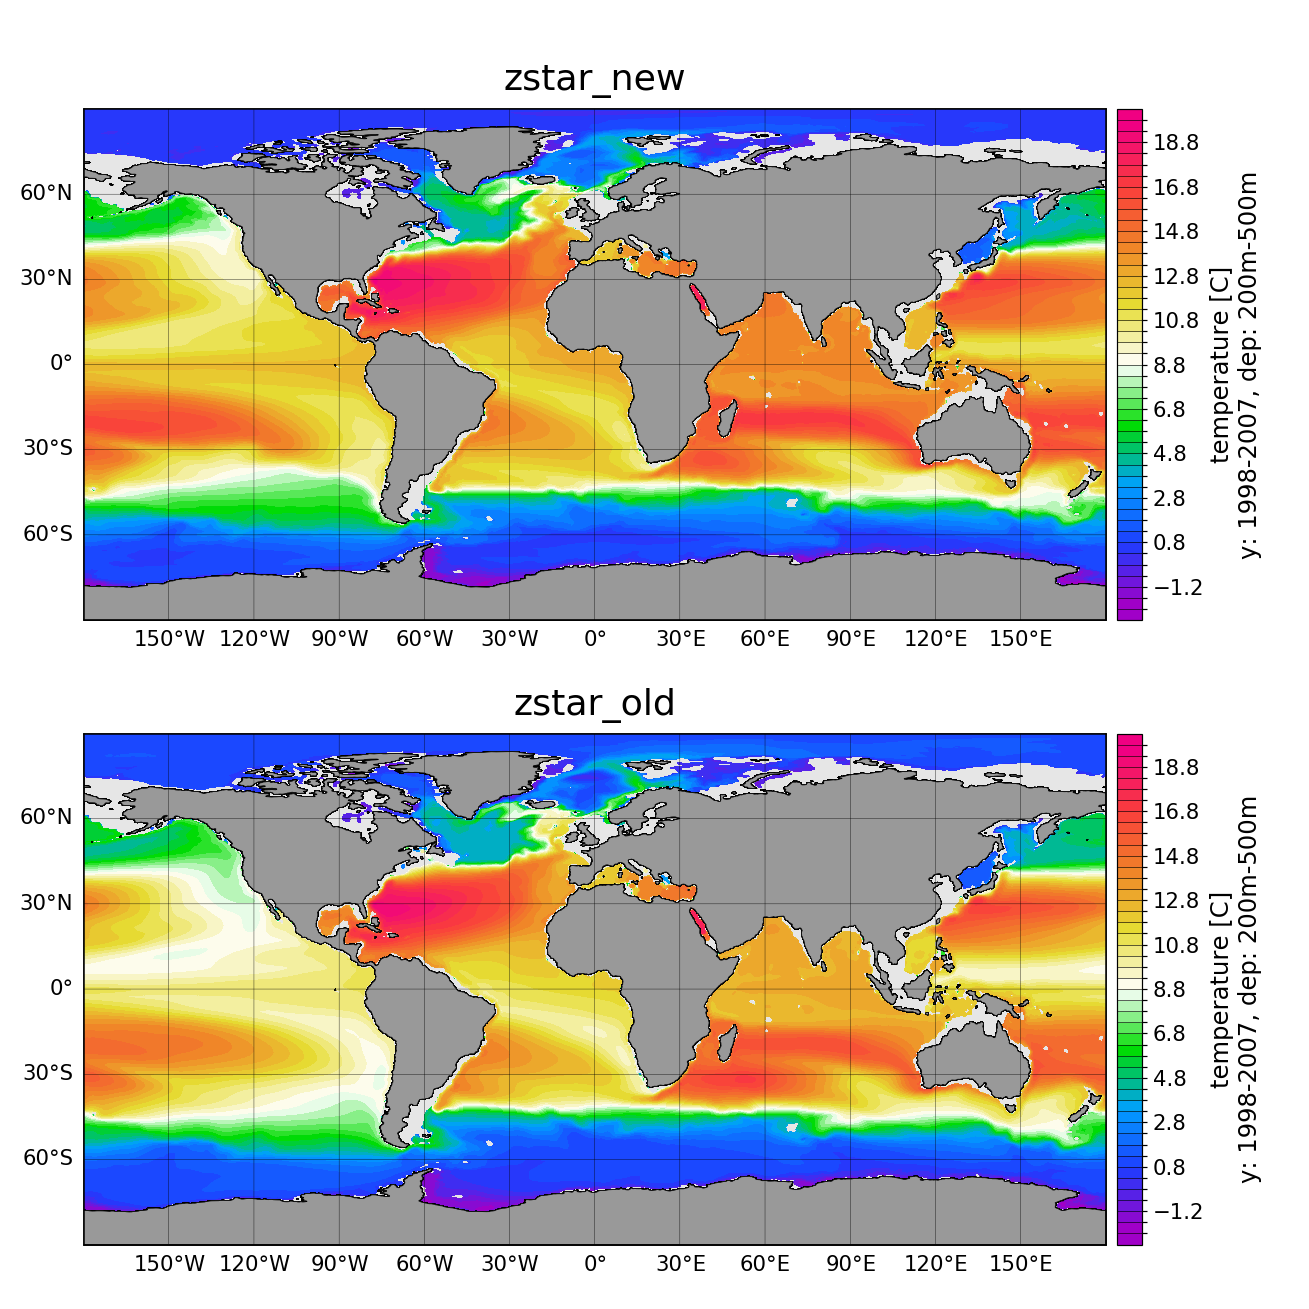

/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_plot.py:246: RuntimeWarning: invalid value encountered in less
  data_plot[data_plot<clevel[0]]  = clevel[0]+np.finfo(np.float32).eps
/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_plot.py:247: RuntimeWarning: invalid value encountered in greater
  data_plot[data_plot>clevel[-1]] = clevel[-1]-np.finfo(np.float32).eps


<IPython.core.display.Javascript object>


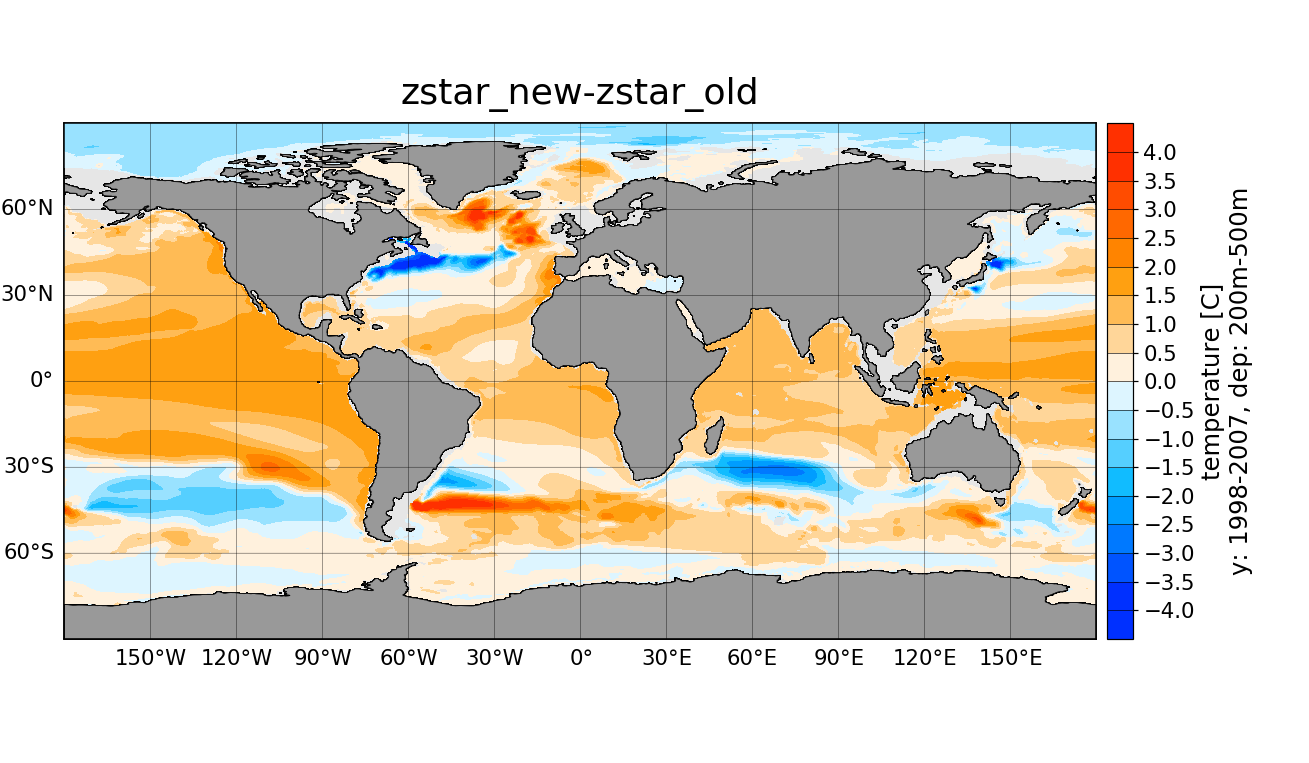

In [5]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** SET INPUT PARAMETER ***                         |
#|                                                                             |
#+_____________________________________________________________________________+
# setup variable name, runid and data path
data 			= fesom_data(inputarray) # init fesom2.0 data object
data.descript,data.path = 'zstar_new' ,'../results/new_zstar/pc0/2/'
data.var 		= 'temp'

#+_____________________________________________________________________________+
# select year to average over [start_yr, end_yr]
data.year		= [1998,2007]

# select month to average over
data.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
# data.month		= [9]
# data.record		= [8]

# select linear interpolated depth layers to average over
# data.depth		= [0]
# data.depth		= np.arange(   0, 200+1,10)
data.depth		= np.arange( 200, 500+1,20)
# data.depth	    = np.arange( 500,1000+1,50)
# data.depth	    = np.arange(1000,2000+1,50)
# data.depth	    = np.arange(2000,3000+1,50)

#+_____________________________________________________________________________+
# make anomaly
do_anomaly      = True
if do_anomaly==True:
    data2 			= cp.deepcopy(data) # init fesom2.0 data object
    data2.descript,data2.path = 'zstar_old' ,'../results/zstar/2/'
    
#+_____________________________________________________________________________+
#|                       *** LOAD FESOM2.0 DATA ***                            |
#+_____________________________________________________________________________+
# plot topography
if data.var=='depth':
    data.value 	= mesh.nodes_2d_zg
    data.sname, data.lname, data.unit, data.cmap = 'depth', 'Depth', 'm', 'wbgyr'
    data.levels = np.arange(0,np.max(data.value),200)# set resolution levels
#_______________________________________________________________________________
# plot triangle resolution interpolated to node
elif data.var=='triresol':
    if len(mesh.nodes_2d_resol)==0: mesh.fesom_calc_triresol()
    data.value 	= mesh.nodes_2d_resol
    data.sname, data.lname, data.unit, data.cmap = 'triresol', 'Resolution', 'km', 'rygbw'
    data.levels = np.arange(0,np.max(data.value),10)# set resolution levels
#_______________________________________________________________________________
# plot triangle area interpolated to node
elif data.var=='triarea':
    if len(mesh.nodes_2d_area)==0: mesh.fesom_calc_triarea()
    data.value 	= mesh.nodes_2d_area
    data.sname,data.lname, data.unit, data.cmap= 'triarea', 'Area', 'km^2', 'cmocean.cm.balance'
    data.levels = np.arange(0,np.max(data.value),10)# set resolution levels
#_______________________________________________________________________________
# load all other 2d and 3d variables
else:
    fesom_load_data_horiz(mesh,data,do_output='False')
    if data.var.find('MLD')!=-1 : data.value = -data.value;
    if do_anomaly==True:
        fesom_load_data_horiz(mesh,data2,do_output='False')
        if data.var.find('MLD')!=-1 : data2.value = -data2.value
        anom = fesom_data_anom(data2,data)

#+_____________________________________________________________________________+
#|                       *** PLOT FESOM2,0 DATA ***                            |
#+_____________________________________________________________________________+
# plot 2d and 2dvec data
if len(data.value2)==0:
    #_______________________________________________________________________
    idx_box = fesom_idxinbox(mesh,data,inputarray)
    
    #___________________________________________________________________________
    # plot anomaly
    if do_anomaly==False:
        cmin,cmax = np.nanmin(data.value[idx_box]),np.nanmax(data.value[idx_box])
        if data.var=='salt':cmin=30.0
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        data.crange,data.cmap,data.cnumb = [cmin,cmax,cref],'grads',40
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,data,figsize=[12,7],do_grid=False)
    else:
        #_______________________________________________________________________
        # interpolate elemental values to nodal vlaues
        if data.value.size  == mesh.n2dea: data.value  = mesh.fesom_interp_e2n(np.array(data.value))
        if data2.value.size == mesh.n2dea: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
        if anom.value.size  == mesh.n2dea: anom.value  = mesh.fesom_interp_e2n(np.array(anom.value))
        
        #_______________________________________________________________________
        # do common crange of absolute
        fac = 1.0
        cmax = np.max([np.nanmax(data.value[idx_box])*fac,np.nanmax(data2.value[idx_box])*fac])
        cmin = np.min([np.nanmin(data.value[idx_box])*fac,np.nanmin(data2.value[idx_box])*fac])
        if data.var=='salt':cmin=30.0
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        if data.var=='ssh':cref=0.0
        data.crange,data2.crange = [cmin,cmax,cref],[cmin,cmax,cref]	
        data.cnumb ,data2.cnumb  = 40, 40
        if data.var=='norm_uv':data.cmap,data2.cmap='wbgyr','wbgyr'
            
        #_______________________________________________________________________
        # plot absolute
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=[12,12])
        fig,ax1,map,cbar ,hp1,tri=fesom_plot2d_data(mesh,data ,do_subplot=[fig,ax1],do_grid=False,do_output=False)
        fig,ax2,map,cbar2,hp2,tri=fesom_plot2d_data(mesh,data2,do_subplot=[fig,ax2],do_grid=False,do_output=False)
        fig.tight_layout(pad=4)
        fig.canvas.draw()   
        
        #_______________________________________________________________________
        #plot anomaly
        fac = 1.0
        anom.crange= [np.nanmin(anom.value[idx_box])*fac,np.nanmax(anom.value[idx_box])*fac, 0.0]
        anom.cnumb  = 10
        if data.var=='temp': anom.crange= [-4.0,4.0, 0.0]
        if data.var=='salt': anom.crange= [-0.5,0.5, 0.0]
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,anom,figsize=[12,7],do_output=False)
        fig.tight_layout(pad=4)
        fig.canvas.draw()
else:
    fesom_plot2dvec_data(mesh,data,figsize=[12,7])